In [1]:
import numpy as np
import time

## Using `numpy.vectorize`

In [2]:
def myfunc(a, b):
    "Return a-b if a>b, otherwise return a+b"
    if a > b:
         return a - b
    else:
         return a + b

In [3]:
vfunc = np.vectorize(myfunc)
print vfunc([1, 2, 3, 4], 2)
print vfunc([1, 2, 3, 4], [4,5,6,8])



[3 4 1 2]
[ 5  7  9 12]


In [4]:
n = 100000
a = np.random.random(n)
b = np.random.random(n)
%timeit c = vfunc(a,b)
print np.sum(vfunc(a,b))

10 loops, best of 3: 47.3 ms per loop
66893.5385301


## Manual vectorization

In [5]:
def ffunc(a,b):
    r = np.zeros(len(a))
    for i in range(len(a)):
        r[i] = myfunc(a[i], b[i])
    return r

In [6]:
%timeit c = ffunc(a,b)
print np.sum(ffunc(a,b))

10 loops, best of 3: 62.8 ms per loop
66893.5385301


## Using numba  vectorization

In [20]:
from numba import vectorize, float64, int64

@vectorize([float64(float64, float64)], target="cpu")
def nfunc(x, y):
    return myfunc(x,y)

In [8]:
%timeit c=nfunc(a,b)
print np.sum(nfunc(a,b))

1 loop, best of 3: 205 ms per loop
66893.5385301


## Using just in time compilation

first plainly with numpy vectorize

In [9]:
from numba import jit, autojit
@autojit
def cfunc(x, y):
    return myfunc(x,y)

vcfunc = np.vectorize(cfunc)


In [10]:
%timeit c = vcfunc(a,b)
print np.sum(vcfunc(a,b))

1 loop, best of 3: 221 ms per loop
66893.5385301


then, compiling function called within and using numpy vectorize

In [11]:
@jit([float64(float64, float64)])
def cmyfunc(a, b):
    "Return a-b if a>b, otherwise return a+b"
    if a > b:
         return a - b
    else:
         return a + b

vccfunc = np.vectorize(cmyfunc)

In [12]:
%timeit c = vccfunc(a,b)
print np.sum(vccfunc(a,b))

10 loops, best of 3: 28 ms per loop
66893.5385301


finally, compiling the function called within and numba vectorize

In [13]:
@vectorize([float64(float64, float64)], target="cpu")
def nccfunc(x,y):
    return cmyfunc(x,y)

In [14]:
%timeit c = nccfunc(a,b)
print np.sum(nccfunc(a,b))

The slowest run took 16.63 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 143 µs per loop
66893.5385301


Compare vectorized compiled addition with native python

In [15]:
@jit([float64(float64, float64)])
def myadd(a, b):
    return a + b

@vectorize([float64(float64, float64)], target="cpu")
def ncadd(x,y):
    return myadd(x,y)


In [16]:
n=100
A = np.random.randint(10,size=(n,n))
B = np.random.randint(10,size=(n,n))

In [17]:
%timeit ncadd(A,B)
print ncadd(A,B)

The slowest run took 14.21 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 41.7 µs per loop
[[ 13.   6.   5. ...,   1.   4.  10.]
 [ 11.   7.  12. ...,   9.  11.  10.]
 [  6.  12.  11. ...,  15.   2.   3.]
 ..., 
 [ 10.  15.   8. ...,   7.   8.  11.]
 [ 16.   8.  12. ...,  11.   9.   2.]
 [  4.   9.   8. ...,   9.  13.   8.]]


In [18]:
%timeit A+B
print A+B

The slowest run took 10.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 10.7 µs per loop
[[13  6  5 ...,  1  4 10]
 [11  7 12 ...,  9 11 10]
 [ 6 12 11 ..., 15  2  3]
 ..., 
 [10 15  8 ...,  7  8 11]
 [16  8 12 ..., 11  9  2]
 [ 4  9  8 ...,  9 13  8]]


but if we use the correct data types it is much faster

In [21]:
@jit([int64(int64, int64)])
def myadd(a, b):
    return a + b

@vectorize([int64(int64, int64)], target="cpu")
def ncadd(x,y):
    return myadd(x,y)


In [22]:
%timeit ncadd(A,B)
print ncadd(A,B)

The slowest run took 34.93 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.32 µs per loop
[[13  6  5 ...,  1  4 10]
 [11  7 12 ...,  9 11 10]
 [ 6 12 11 ..., 15  2  3]
 ..., 
 [10 15  8 ...,  7  8 11]
 [16  8 12 ..., 11  9  2]
 [ 4  9  8 ...,  9 13  8]]


## An example with Fractals

first with regular python code

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from timeit import default_timer as timer

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters

In [24]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

Mandelbrot created in 9.860558 s


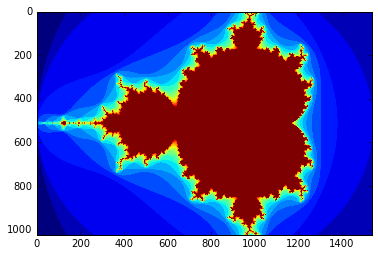

In [25]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print "Mandelbrot created in %f s" % dt
plt.imshow(image)

now using numba compilation

In [26]:
from numba import autojit

@autojit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters

@autojit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

Mandelbrot created in 0.320305 s


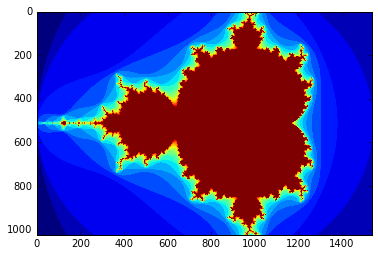

In [27]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print "Mandelbrot created in %f s" % dt
plt.imshow(image)

and finally, vectorizing the implementation

In [31]:
from numba import autojit, jit, vectorize, int64, float64
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from timeit import default_timer as timer

@jit(int64(float64, float64))
def mandel(x, y):
    max_iters = 20
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters            
            
@vectorize([int64(float64, float64)],target="cpu")
def vcreate_fractal(x,y):
    return mandel(x,y)

Mandelbrot created in 0.087635 s


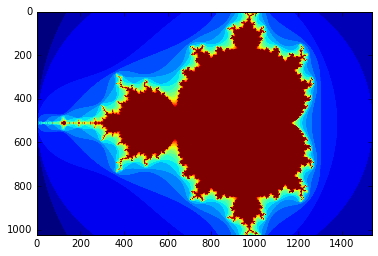

In [56]:
x_range = np.linspace(-2,1,1536)
y_range = np.linspace(-1,1,1024)
xx,yy = np.meshgrid(x_range, y_range)
start = timer()
ximg = vcreate_fractal(xx,yy)
dt = timer() - start
print "Mandelbrot created in %f s" % dt
plt.imshow(img)

Mandelbrot created in 0.154310 s


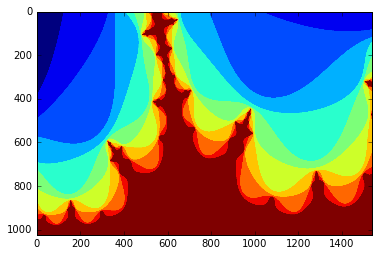

In [57]:
x_range = np.linspace(-1.5,-1.45,1536)
y_range = np.linspace(-.025,0,1024)
xx,yy = np.meshgrid(x_range, y_range)
start = timer()
img = vcreate_fractal(xx,yy)
dt = timer() - start
print "Mandelbrot created in %f s" % dt
plt.imshow(img)